# SISO LINEAR MODULAR (SLM) REACTION NETWORKS

This notebook contains numerical studies to check the derivation of transfer functions for compositions
of SLM reaction networks.

In [1]:
import sys
sys.path.insert(0, "/Users/jlheller/home/Technical/repos/controlSBML/src")

In [2]:
import lrn_builder.slm_network

In [3]:
import numpy as np
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
import sympy as sp
import control
from lrn_builder.slm_network import SLMNetwork

# Helpers 

In [4]:
TEST_MODEL = """
model *main()
$SI -> SO; TEST_KIO*SI
SO ->; TEST_KO*SO

SI = 0
TEST_KIO = 2
TEST_KO = 1
end
"""

In [5]:
TEST_KIO = 2
TEST_KO = 1
TEST_TF = control.TransferFunction([TEST_KIO], [1, TEST_KO])

In [6]:
def plotStep(model=None, tf=None, title="", figsize=(8, 8), is_plot=True, **kwargs):
    """
    Assumes that input is SI and output is SO

    Args:

    Returns:
        np.array (data from simulation)
        np.array (predictions)
    """
    if "SI" in kwargs.keys():
        SI = kwargs["SI"]
    else:
        raise ValueError("Must specify input SI")
    #
    _, ax = plt.subplots(1, figsize=figsize)
    if model is not None:
        rr = te.loada(model)
        for key, value in kwargs.items():
            rr[key] = value
        selections = ["time", "SO"]
        data = rr.simulate(selections=selections)
    else:
        data = None
    if data is None:
            times = np.linspace(0, 5, 50)
    else:
        times = data["time"]
    if tf is not None:
        times, predictions = control.step_response(tf, T=times)
        predictions = SI*predictions
    else:
        predictions = None
    if (tf is not None) and (model is not None):
        ax.scatter(data[:, 1], predictions, color="red", marker="*")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        max_simulated = np.max(data[:, 1])
        max_predictions = np.max(predictions)
        max_value = max(max_simulated, max_predictions)
        ax.plot([0, max_value], [0, max_value], linestyle="--")
    else:
        if data is not None:
            ax.scatter(times, data[:, 1], marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("simulations")
        elif predictions is not None:
            ax.scatter(times, predictions, marker="o")
            ax.set_xlabel("time")
            ax.set_ylabel("predictions")
    ax.set_title(title)
    if not is_plot:
        plt.close()
    return data, predictions

# Tests
is_plot = False
data, _ = plotStep(model=TEST_MODEL, SI=5, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
assert(data[-1, 1] > 0)
_ = plotStep(SI=5, tf=TEST_TF, TEST_K12=TEST_KIO, TEST_K2=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
_ = plotStep(model=TEST_MODEL, SI=5, tf=TEST_TF, TEST_KIO=TEST_KIO, TEST_KO=TEST_KO, title="test", figsize=(3,3), is_plot=is_plot)
print("OK!")

OK!


# Sequential SLM Reaction Network

# Scale Operation

# Concatenate Operation

In [7]:
slm1 = SLMNetwork.makeTwoSpeciesNetwork(1, 1)
slm1.template


        model <<model_name>>()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 1.000000
        kO = 1.000000
        SI = 0
        SO = 0
        end
        

In [8]:
slm2 = SLMNetwork.makeTwoSpeciesNetwork(2, 2)
slm2.template


        model <<model_name>>()
        SI -> SO; kIO*SI
        SO -> ; kO*SO
        kIO = 2.000000
        kO = 2.000000
        SI = 0
        SO = 0
        end
        

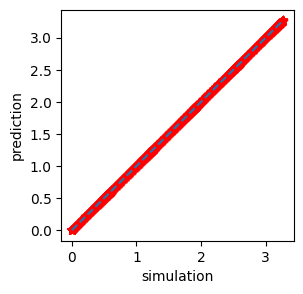

In [9]:
slm_concatenate = slm1.concatenate(slm2)
_ = slm_concatenate.plotTransferFunctionEvaluation(figsize=(3,3))

In [14]:
control.TransferFunction.s

TransferFunction(array([1, 0]), array([1]))

For all models, S1 is the input and S2 is the output.

# Forkjoin Operation

In [ ]:
model_forkjoin = """
model *main()
$SI -> S2A; k12A*SI
S2A ->; k2A*S2A
$SI -> S2B; k12B*SI
S2B ->; k2B*S2B
SO := S2A + S2B
SI =5
k12A =3
k12B = 2
k2A = 2
k2B = 2
S2A = 0
S2B = 0
end
"""

In [ ]:
k12A = 5
k2A = 1
k12B = 3
k2B = 2
S1 = 5
tf1 = control.TransferFunction([k12A], [1, k2A])
tf2 = control.TransferFunction([k12B], [1, k2B])
tf = tf1 + tf2
_ = plotStep(model=model_forkjoin, tf=tf, SI=SI, k12A=k12A, k2A=k2A, k12B=k12B, k2B=k2B, title="forkjoin", figsize=(5,5))

# Loop Operation

\begin{eqnarray}
H(s) & = & \frac{ k_1  k_2 k_3 k_4 G(s)}
{s \left( s^2 + (k_2 + k_4 +k_5)s + k_2 k_4 + k_2 k_ 5 - k_2 k_3 k_5 G(s) \right)} \\
\end{eqnarray}


In [ ]:
# Get correct poles and zeroes. So problem is with the math.
# 
def loopTransferFunction(model_tf, k1, k2, k3, k4, k5, k6, knI, knO):
    """
    Constructs the transfer function from S_I to S_O for the loop operation.

    Args:
        model_tf: Transfer function (of the network being looped)
        k1, k2, k3, k4, k5, k6: float (Parameters of the loop operation)
        kn: float (k_O^N, degradation constant for the output of the network being looped)
    """
    # Calculate terms
    s = control.TransferFunction.s
    K1 = k1*k2*k3*k4
    K2 = k2*k3*k5
    D1 = control.TransferFunction([1, k2], [1])
    D2 = control.TransferFunction([1, k4+k5], [1])
    D = D1*D2
    C = control.TransferFunction([1], [1, knI])*control.TransferFunction([1, knO], [1, knO + k3])
    # Denominator
    denom_tf = (s + k6)*(D - K2*C*model_tf)
    numr_tf = K1*C*model_tf
    #
    tf = numr_tf/denom_tf
    return tf

# Tests
model_tf = control.TransferFunction([1], [1, 1])
model_tf = control.TransferFunction([1], [1])
k1 = 1; k2 = 1; k3 =1; k4 =1; k5 = 0.8; k6=1; knO=2; knI=1
tf = loopTransferFunction(model_tf, k1, k2, k3, k4, k5, k6, knI, knO) 
assert(isinstance(tf, control.TransferFunction))
print("OK!")

In [ ]:
# The looped network is S1A -> S2A, S2A ->;
model_loop = """
model *main()
species XO;
// Reactions external to looped network
J__SI__XI: $SI -> XI; k1*SI
J__XI__N_SI: XI -> N_SI; k2*XI
J3: N_SO -> XO; k3*N_SO
J4: XO -> SO; k4*XO
J4a: SO ->; k6*SO
// Looped network
J5: N_SI -> N_SO; kIO*N_SI
J6: N_SO -> ; kO*N_SO
// Added reactions
J7: XO -> XI; k5*XO
SI =5
N_SI = 0
N_SO = 0
SO = 0
#
k1 = 1
k2 = 1
k3 = 1
k4 = 1
k5 = 0.8
k6 = 0.5
kIO = 3
kO = 2
end
"""
rr = te.loada(model_loop)
data_S = rr.simulate(1, 10, 100, selections=["time", "SI", "SO", "XI", "XO", "N_SO", "N_SI"])
rr.plot()
rr.reset()
#rr.simulate(1, 10, 100, selections=["time", "J1", "J2", "J3", "J4", "J5", "J6", "J7"])
data_J = rr.simulate(1, 100, 1000, selections=["time", "J3", "J5", "J6", "N_SO'", "N_SI'"])
rr.plot()

\begin{eqnarray}
s S_O (s) & = & k_4 X_O (s)  \\
s X_I (s) & = & k_5 X_O(s) + k_1 S_I (s) - k_2 X_I (s) \\
s N.S_I (s) & = & k_2 X_I(s) - N.k_I N.S_I(s) \\
\end{eqnarray}

In [ ]:
k1 = 1; k2 = 10; k3 = 1; k4=1; k5=0.2; k6=0.5
kIO = 10; kO =20; SI=5
inner_tf = control.TransferFunction([kIO], [1, kO])
tf = loopTransferFunction(inner_tf, k1, k2, k3, k4, k5, k6, kIO, kO)
#_ = plotStep(model=model_loop, tf=tf, figsize=(3, 3), k=k, k1=k1, k2=k2, SI=SI, kIO=kIO, kO=kO)
#_ = plotStep(model=model_loop, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, SI=SI, kIO=kIO, kO=kO)
#_ = plotStep( tf=tf, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, SI=SI, kIO=kIO, kO=kO)
_ = plotStep(model=model_loop, tf=tf, figsize=(3, 3), k1=k1, k2=k2, k3=k3, k4=k4, k5=k5, k6=k6, SI=SI, kIO=kIO, kO=kO)